In [133]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, RepeatedKFold, 
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [69]:
!curl -O https://raw.githubusercontent.com/javaeeeee/MachineLearningNotebooks/main/utils.ipynb
%run utils.ipynb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3302  100  3302    0     0   8924      0 --:--:-- --:--:-- --:--:--  8924


In [40]:
boston = load_boston()
boston.data.shape, boston.target.shape

((506, 13), (506,))

In [41]:
X = pd.DataFrame(data=boston.data, columns=boston.feature_names)
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [42]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [44]:
y = boston.target

In [45]:
full_data = X.copy()
full_data["target"] = y

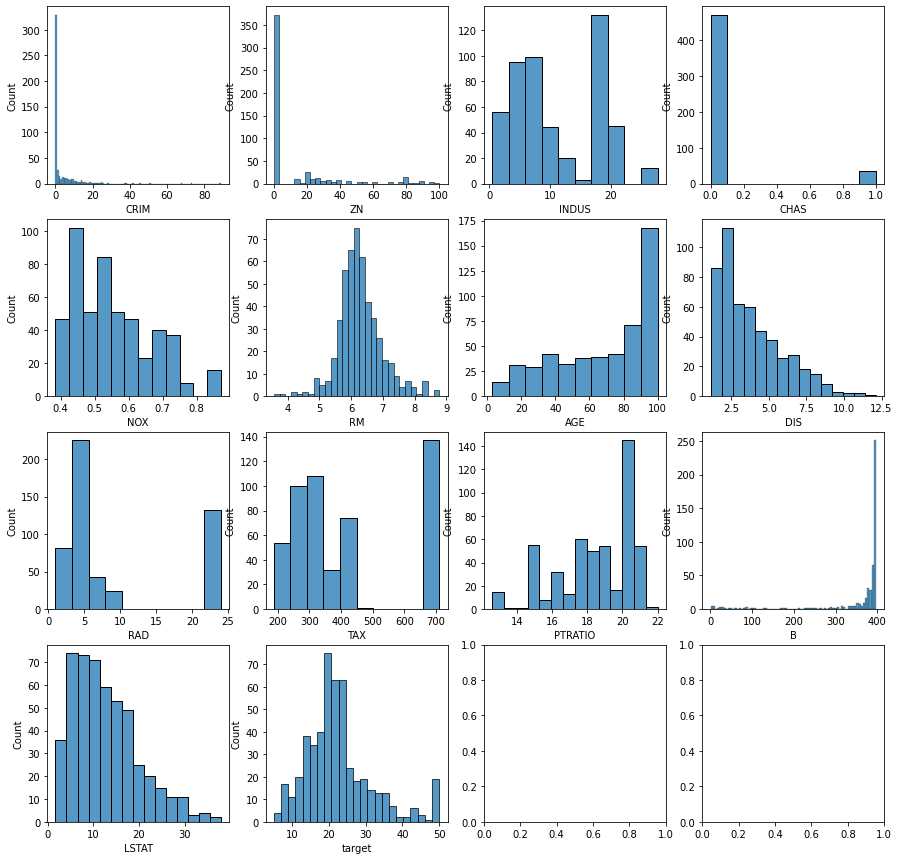

In [46]:
plot_distributions(full_data, 4, 4, 13, 15, 15)

In [47]:
correlation = full_data.corr()

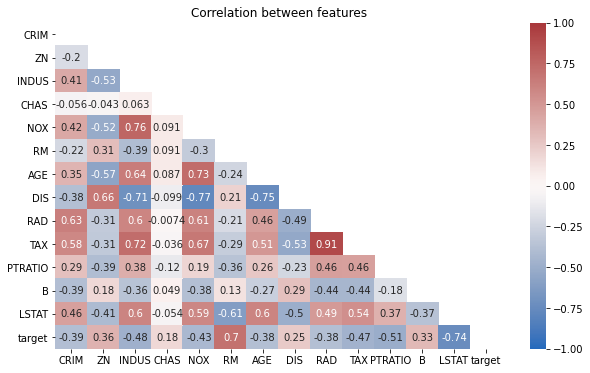

In [70]:
plot_correlation_between_features(correlation, 10, 6)

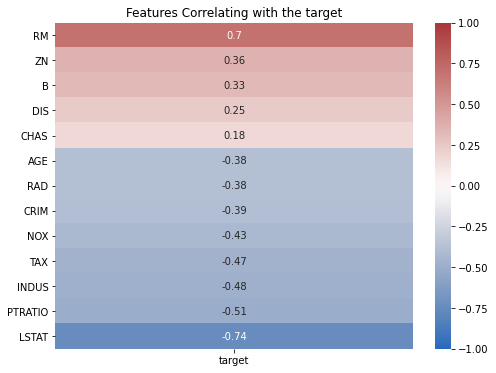

In [71]:
plot_correlation_with_target(correlation, 8, 6, "target")

In [50]:
del X["TAX"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [143]:
def tune_hyperparams(estimator, param_grid):
  """
  Performs grid search with k-fold cross-validation
  for hyperparameter tuning
  :param estimator - The estimator to tune hyperparameters for
  :param param_grid - Hyperparameters to try during tuning
  :return - GridSearchCV object
  """
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  gs = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv)
  gs.fit(X_train, y_train)
  return gs


def print_tuning_results(gs, x_test):
  """
  Function prints hypermarameter tuning results
  :param gs - GridSearchCV object
  :param x_test - A Pandas DataFrame with test features
  :return None
  """
  print("Best Params {}".format(str(gs.best_params_)))
  print("Best Score {0:.3f}".format(gs.best_score_))
  y_pred = gs.best_estimator_.predict(x_test)
  print("MSE = {0:.3f}, R2 Score {1:.3f}".format(mean_squared_error(y_true=y_test, y_pred=y_pred),
                                                 r2_score(y_true=y_test, y_pred=y_pred)))

In [144]:
def transform_target(x):
  return np.log(x)

def inverse(x):
  return np.exp(x)

In [145]:
estimators = [
              {
                "name": "Elastic Net",
                "param_grid": {
                  "estimator__regressor__alpha" : np.logspace(-5,2,11),
                  "estimator__regressor__l1_ratio" : np.linspace(0.01,1,5)
                },
                "estimator": Pipeline([
                    ("estimator", TransformedTargetRegressor(
                      regressor=ElasticNet(max_iter=int(1e5), normalize=True, random_state=1),
                      func=transform_target,
                      inverse_func=inverse
                  ))])
              },
              {
                "name": "Random Forest",
                "param_grid": {
                  "n_estimators" : [int(ne) for ne in np.linspace(start=10, stop=510, num=10)],
                  "max_features" : ["sqrt", "log2", None]
                },
                "estimator": RandomForestRegressor(random_state=1)
              },
              {
                "name": "Gradient Boosted Regressor",
                "param_grid": {
                  "n_estimators": [int(ne) for ne in np.linspace(100, 600, 6)],
                  "max_depth": range(1, 7),
                  "min_samples_split": [5],
                  "learning_rate": np.logspace(-5, -1, 5),
                  "loss": ['ls']
                },
                "estimator": GradientBoostingRegressor(random_state=1)
              }
]

In [146]:
for estimator in estimators:
  gs = tune_hyperparams(estimator=estimator["estimator"], param_grid=estimator["param_grid"])
  print(estimator["name"])
  print_tuning_results(gs, X_test)

Elastic Net
Best Params {'estimator__regressor__alpha': 1e-05, 'estimator__regressor__l1_ratio': 0.7525}
Best Score 0.730
MSE = 21.580, R2 Score 0.782
Random Forest
Best Params {'max_features': None, 'n_estimators': 410}
Best Score 0.845
MSE = 9.406, R2 Score 0.905
Gradient Boosted Regressor
Best Params {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best Score 0.859
MSE = 10.582, R2 Score 0.893


In [152]:
regressor = RandomForestRegressor(n_estimators=410, max_features=None, random_state=1)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=410, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [153]:
y_pred = regressor.predict(X_test)
print("MSE = {0:.3f}, R2 Score {1:.3f}".format(mean_squared_error(y_true=y_test, y_pred=y_pred),
                                                r2_score(y_true=y_test, y_pred=y_pred)))

MSE = 9.406, R2 Score 0.905


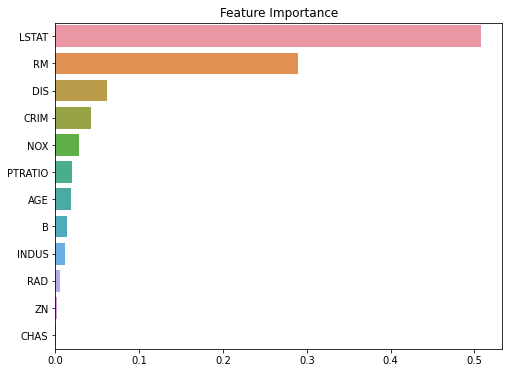

In [154]:
plot_feature_importance(regressor.feature_importances_, 8, 6)